# Mašinsko učenje - projekat
Student: Kenan Sultanić, 6199/M <br>
Predmetna asistentica: Adisa Bolić

U ovom projektu demonstrirat ću primjenu nekoliko algoritama mašinskog učenja za binarnu klasifikaciju. Dataset se odnosi na medicinske podatke pacijenata i koristi se za predikciju prisustva srčane bolesti. Ciljna varijabla je **HeartDisease** (0 – nema bolest, 1 – ima bolest), dok ostale kolone predstavljaju demografske i kliničke karakteristike pacijenata, poput starosti, krvnog pritiska, nivoa holesterola, rezultata EKG-a, tipa bola u grudima i drugo.

Analiza će uključivati sljedeće korake:
- Istraživanje i vizualizaciju podataka
- Predobradu podataka (čišćenje podataka, enkodiranje kategorijalnih varijabli, skaliranje)
- Treniranje i evaluaciju više modela klasifikacije
- Poređenje performansi modela pomoću metrika kao što su accuracy, precision, recall, F1-score, ROC-AUC, confusion matrix i distribucija vjerovatnoća

U fokusu će biti tri algoritma:
- Logistička regresija
- SVM (Mašina potpornih vektora)
- k-nearest neighbours (KNN)

Cilj je uporediti njihove performanse i identifikovati najefikasniji pristup za predikciju srčane bolesti na osnovu dostupnih karakteristika pacijenata.
<br> <br>
Projekat je organizovan u više foldera radi bolje preglednosti i modularnosti:
- `data` folder sadrži CSV fajl sa originalnim podacima koji se koriste za analizu i treniranje modela.
- `logics` folder sadrži fajl functions.py, u kojem su implementirane pomoćne funkcije za statističke analize i vizualizacije, kao što su metričke evaluacije, prikaz matrice konfuzije, ROC krive i distribucije vjerovatnoća.

## Učitavanje i priprema podataka

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn.metrics as metrics

from logics.functions import *

%load_ext autoreload
%autoreload 2

In [2]:
data = pd.read_csv("./data/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Skup podataka sadrži 918 redova i 12 kolona bez nedostajućih vrijednosti, s kombinacijom numeričkih i kategorijskih varijabli.

In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Sve numeričke kolone izuzev **RestingBP** i **Cholesterol** pokazuju realistične vrijednosti. <br>
Vrijednosti 0 za RestingBP (krvni pritisak u mirovanju) i Cholesterol su sumnjive zato što fiziološki nije moguće da osoba ima krvni pritisak od 0 mmHg ili nivo holesterola od 0 mm/dl dok je živa. Ovo znači da je podatak vjerovatno nedostajao pa je zamijenjen nulom, ili je došlo do greške pri unosu. U svakom slučaju, izbacit cemo uzorke koji imaju RestingBP jednak 0 ili Cholesterol jednak 0.

In [5]:
# Uklanjanje sumnjivih redova
data = data[(data['RestingBP'] != 0) & (data['Cholesterol'] != 0)]

In [6]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,0.167560,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,0.373726,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Podaci sada imaju realistične vrijednosti.

In [7]:
print(data['HeartDisease'].unique())
print(data['ChestPainType'].unique())
print(data['FastingBS'].unique())
print(data['RestingECG'].unique())
print(data['ExerciseAngina'].unique())
print(data['ST_Slope'].unique())

[0 1]
['ATA' 'NAP' 'ASY' 'TA']
[0 1]
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


Provjera jedinstvenih vrijednosti u kategorijalnim i binarnim kolonama kako bismo ih pripremili za enkodiranje.

In [39]:
print(f"Broj pacijenata sa srčanim oboljenjem: {len(data[data['HeartDisease'] == 1])}")
print(f"Broj pacijenata bez srčanog oboljenja: {len(data[data['HeartDisease'] == 0])}")

Broj pacijenata sa srčanim oboljenjem: 356
Broj pacijenata bez srčanog oboljenja: 390


In [9]:
# One-hot encoding podataka
data = pd.get_dummies(data, columns=['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'Sex'], drop_first=True)

In [10]:
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up,Sex_M
0,40,140,289,0,172,0.0,0,1,0,0,1,0,0,0,1,1
1,49,160,180,0,156,1.0,1,0,1,0,1,0,0,1,0,0
2,37,130,283,0,98,0.0,0,1,0,0,0,1,0,0,1,1
3,48,138,214,0,108,1.5,1,0,0,0,1,0,1,1,0,0
4,54,150,195,0,122,0.0,0,0,1,0,1,0,0,0,1,1


In [38]:
# Podjela podataka na trening i test skupove
df_train, df_test = train_test_split(data)

print(f"Veličina trening skupa: {len(df_train)}")
print(f"Veličina testnog skupa: {len(df_test)}")

Veličina trening skupa: 596
Veličina testnog skupa: 150


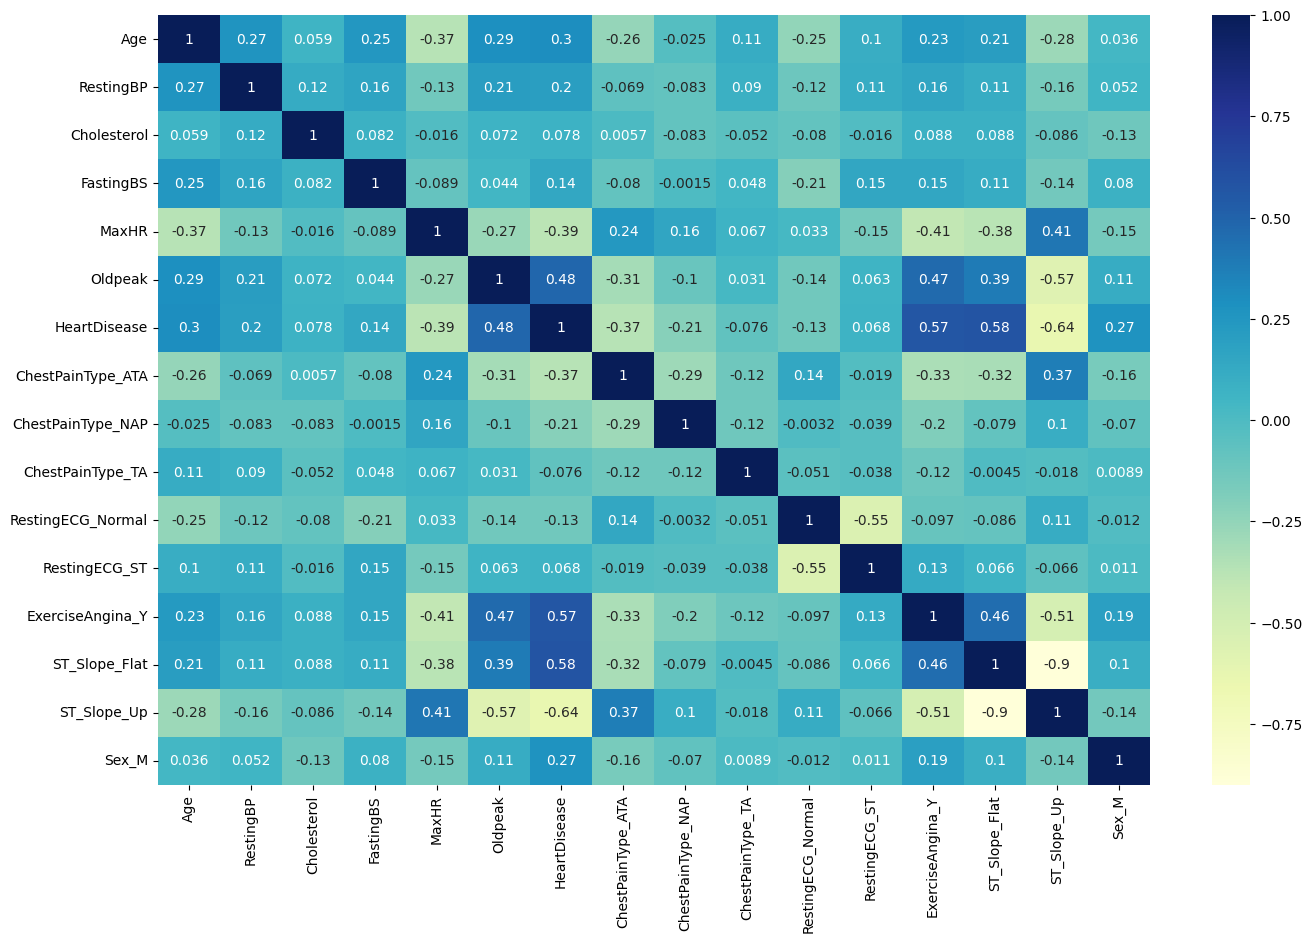

In [12]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

Ova korelaciona mapa prikazuje međuzavisnost između varijabli.

In [13]:
y_train = np.array(df_train.pop('HeartDisease'))
X_train = df_to_matrix(df_train)

y_test = np.array(df_test.pop('HeartDisease'))
X_test = df_to_matrix(df_test)

In [14]:
# Skaliranja značajki (standardizacija)
from sklearn.preprocessing import StandardScaler

train_std_scaler = StandardScaler()

X_train_std = train_std_scaler.fit_transform(X_train)
X_test_std = train_std_scaler.transform(X_test)

## Logistička regresija i RFE

In [15]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2')

# Zadržavamo 10 značajki
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train_std, y_train)

,estimator,LogisticRegre...r='liblinear')
,n_features_to_select,10
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [16]:
selected_features = df_train.columns[rfe.support_]
print("Odabrane značajke:", selected_features.tolist())

Odabrane značajke: ['Age', 'RestingBP', 'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M']


10 najrelevantnijih značajki koje je RFE algoritam odabrao i koje najviše doprinose predikciji srčane bolesti. Ove značajke ćemo koristiti i za učenje modela SVM-a.

In [17]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [18]:
model.fit(X_train_rfe, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
y_test_pred = model.predict(X_test_rfe)

In [20]:
print_metrics(y_test, y_test_pred)

Accuracy: 0.8933333333333333
Precision: 0.92
Recall: 0.8734177215189873
F1 Score: 0.8961038961038961


Model pokazuje visoku tačnost (89.3%), uz odličnu preciznost (92%) i odziv (87%), što znači da dobro balansira između tačnog prepoznavanja bolesnih pacijenata i izbjegavanja lažnih uzbuna. Visok F1-score (0.896) potvrđuje da model pouzdano prepoznaje srčanu bolest.

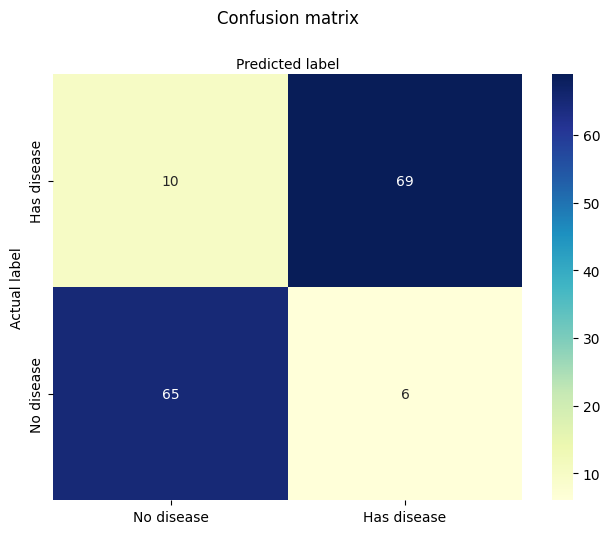

In [21]:
plot_confusion_matrix(y_test, y_test_pred)

Model je tačno klasificirao 69 pacijenata sa bolešću i 65 bez bolesti. Broj lažno negativnih (10) i lažno pozitivnih (6) je nizak, što ukazuje na dobru sposobnost modela da razlikuje bolesne od zdravih pacijenata.

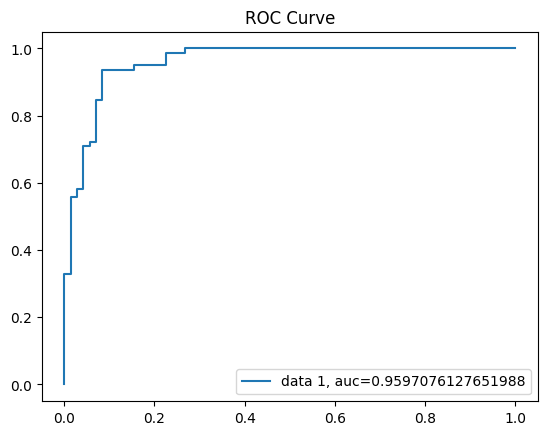

In [22]:
y_pred_proba = model.predict_proba(X_test_rfe)[::,1]
plot_roc_curve(y_test,  y_pred_proba)

ROC kriva prikazuje sposobnost modela da razlikuje klase pri različitim pragovima, a AUC vrijednost od 0.96 ukazuje na visoku tačnost u klasifikaciji pacijenata sa i bez srčane bolesti.

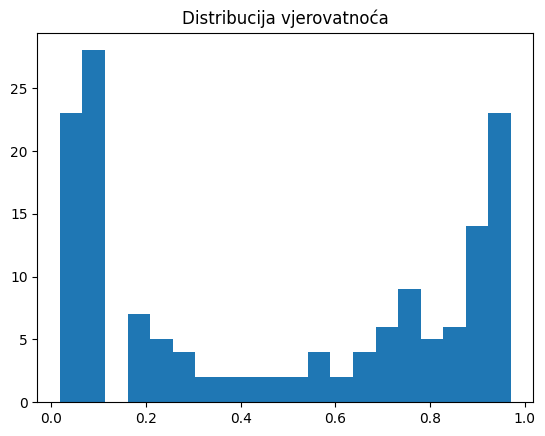

In [23]:
plot_probability_distribution_hist(y_pred_proba)

Ovaj histogram prikazuje raspodjelu vjerovatnoća koje je model dodijelio klasi "ima srčanu bolest", gdje većina predikcija ima vjerovatnoće blizu 0 ili 1, što ukazuje na visoko samopouzdanje modela u donošenju odluka.

## SVM

In [24]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train_rfe, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [25]:
y_test_pred = model.predict(X_test_rfe)

In [26]:
print_metrics(y_test, y_test_pred)

Accuracy: 0.9066666666666666
Precision: 0.922077922077922
Recall: 0.8987341772151899
F1 Score: 0.9102564102564102


Model SVM-a postiže nešto višu tačnost (90.7%) i F1-score (0.91) u odnosu na logističku regresiju, uz zadržanu visoku preciznost (92%) i bolji odziv (89.9%), što ga čini nešto efikasnijim u detekciji bolesnih pacijenata.

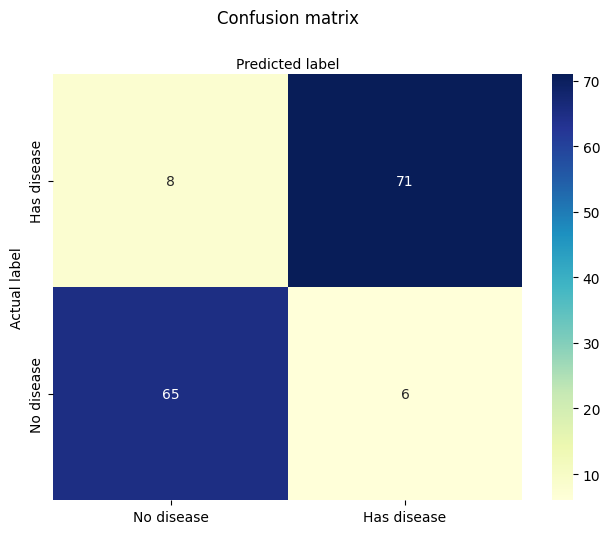

In [27]:
plot_confusion_matrix(y_test, y_test_pred)

Matrica konfuzije za SVM pokazuje da je model tačno klasifikovao 71 pacijenta sa srčanom bolešću i 65 bez, uz manji broj lažno negativnih (8) i lažno pozitivnih (6), što potvrđuje njegovu visoku preciznost i pouzdanost u prepoznavanju obe klase.

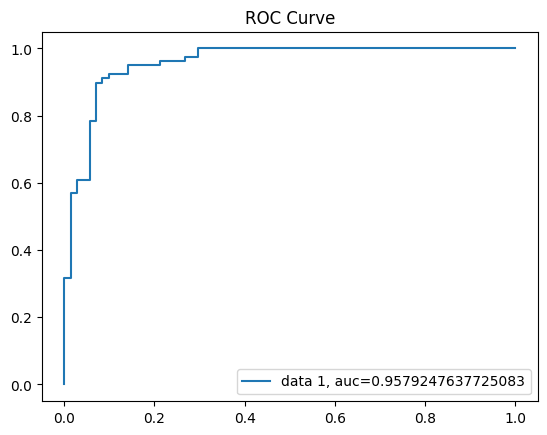

In [28]:
y_pred_proba = model.predict_proba(X_test_rfe)[::,1]
plot_roc_curve(y_test, y_pred_proba)

ROC kriva za SVM model daje AUC vrijednost od 0.958, gotovo jednaku onoj kod logističke regresije (0.96), što potvrđuje da oba modela vrlo pouzdano razlikuju klase.

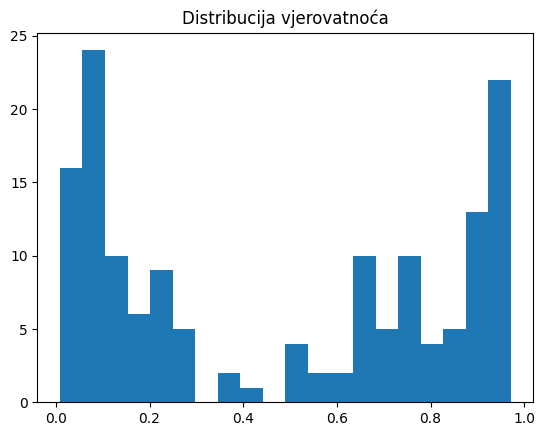

In [29]:
plot_probability_distribution_hist(y_pred_proba)

Distribucija vjerovatnoća za SVM pokazuje da model često dodjeljuje vrlo niske ili vrlo visoke vjerovatnoće, što ukazuje na visoko samopouzdanje u svoje odluke, iako ima nešto više nesigurnih predikcija u srednjem opsegu u poređenju s logističkom regresijom.

## KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

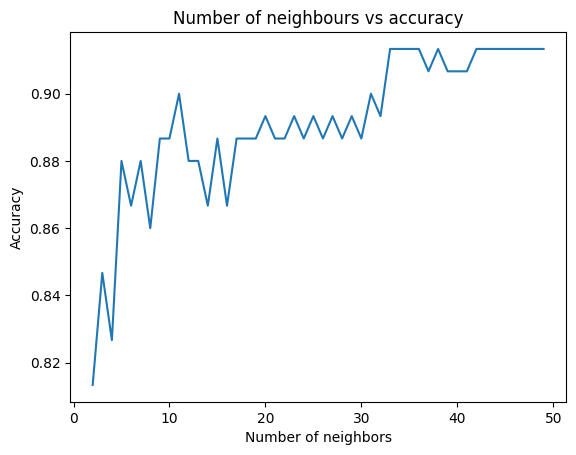

In [31]:
import matplotlib.pyplot as plt

acc = []
for k in range(2, 50):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_std, y_train)
  pred = knn.predict(X_test_std)
  acc.append(accuracy_score(y_test, pred))

plt.plot(range(2, 50), acc)
plt.title("Number of neighbours vs accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

Na osnovu grafikona vidimo da se tačnost naglo poboljšava za k ≈ 10 susjeda, zatim osciluje i stabilizuje nakon k ≈ 33 susjeda. Primjenom metode lakta, kao optimalnu vrijednost biramo k = 11 susjeda.

In [32]:
# Model KNN treniramo nad standardizovanim podacima, bez primjene RFE algoritma, budući da u toj varijanti postiže višu tačnost.
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_std, y_train)

,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [33]:
y_test_pred = knn.predict(X_test_std)

In [34]:
print_metrics(y_test, y_test_pred)

Accuracy: 0.9
Precision: 0.9324324324324325
Recall: 0.8734177215189873
F1 Score: 0.9019607843137255


KNN model postiže tačnost od 90%, što je vrlo slično SVM-u i nešto više od logističke regresije. Ima najvišu preciznost (93.2%), ali nešto niži recall (87.3%) u poređenju sa SVM-om. F1-score (0.902) pokazuje da KNN takođe postiže dobar balans, ali SVM i dalje ostaje blago najuravnoteženiji model ukupno.

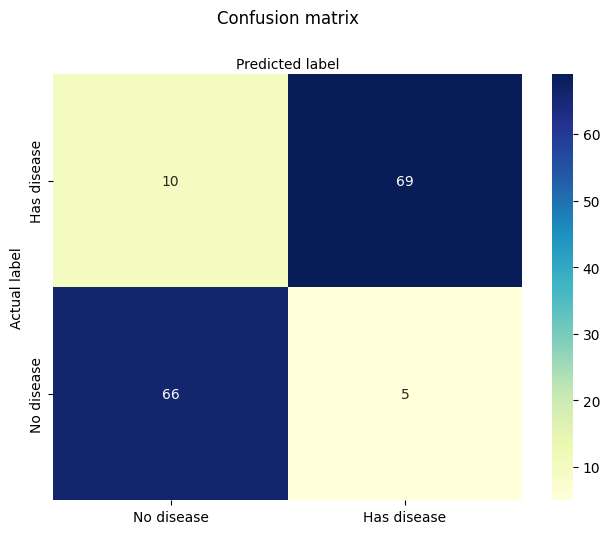

In [35]:
plot_confusion_matrix(y_test, y_test_pred)

KNN matrica konfuzije pokazuje da je model tačno predvidio 69 pacijenata sa bolešću i 66 bez, uz 10 lažno negativnih i 5 lažno pozitivnih. Iako su greške blago prisutne, raspodjela ukazuje na dobru sposobnost modela da razlikuje obje klase.

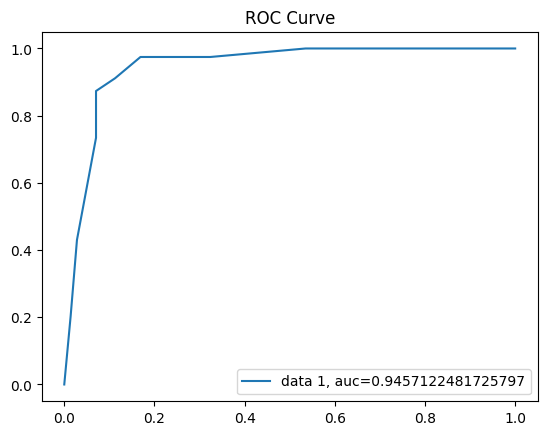

In [36]:
y_pred_proba = knn.predict_proba(X_test_std)[::,1]
plot_roc_curve(y_test, y_pred_proba)

KNN model ima AUC vrijednost od 0.946, što je vrlo blizu vrijednosti logističke regresije (0.960) i SVM-a (0.958). To znači da KNN takođe odlično razlikuje pacijente sa i bez bolesti, iako je u nijansama slabiji u poređenju s prethodna dva modela.

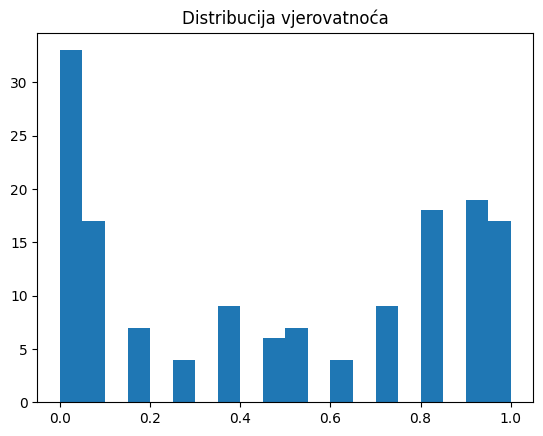

In [37]:
plot_probability_distribution_hist(y_pred_proba)

Distribucija vjerovatnoća za KNN pokazuje izraženu koncentraciju predikcija blizu 0 i 1, što znači da je model često vrlo siguran u svoje odluke. Međutim, za razliku od logističke regresije i SVM-a, postoji više predikcija u srednjem rasponu, što ukazuje na veću nesigurnost kod određenih uzoraka.